In [10]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

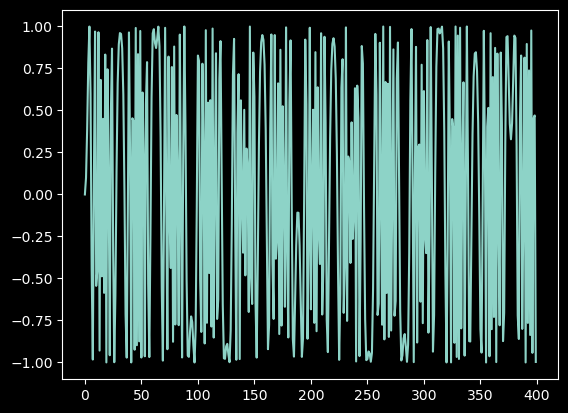

In [11]:
# Synthetic data
series = np.sin(0.1 * np.arange(0, 400) ** 2)

plt.plot(series)
plt.show()

In [12]:
# Reshape the data for training
T = 10
X = np.array(series[0:T])
Y = np.array(series[T])

for t in range(1, len(series) - T):
    X = np.vstack((X, series[t:t+T]))
    Y = np.hstack((Y, np.array(series[t+T])))

N = X.shape[0]
X = X.reshape(N, T, -1)
Y = Y.reshape(N, -1)
X.shape, Y.shape

((390, 10, 1), (390, 1))

In [13]:
# RNN model with GRU and LSTM
class GRU_RNN(nn.Module):
    def __init__(self, num_inputs, num_outs, num_hiddens, num_layers):
        super(GRU_RNN, self).__init__()
        
        self.L = num_layers
        self.D = num_inputs
        self.K = num_outs
        self.M = num_hiddens
        
        # The RNN layer
        self.rnn = nn.GRU(
            input_size=self.D,
            hidden_size=self.M, 
            num_layers=self.L,
            batch_first=True
        )
        
        # Dense layer
        self.dense = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # Initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M)
        
        # Here we only care about the last layer (NxTxM)
        out, _ = self.rnn(X, h0)
        
        # Pass the last time step into the dense layer
        out = self.dense(out[:, -1, :])
        return out  # Shape is NxK

In [14]:
class LSTM_RNN(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens, num_layers):
        super(LSTM_RNN, self).__init__()
        
        self.L = num_layers
        self.D = num_inputs
        self.M = num_hiddens
        self.K = num_outputs
        
        # RNN layer
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        
        # Dense layer
        self.dense = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states and cells
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        
        # We only care about the last layer
        out, _ = self.rnn(X, (h0, c0))
        
        # We again care about the last time step
        out = self.dense(out[:, -1, :])
        return out

In [15]:
# Change the data into torch Tensors
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [16]:
# train the model
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs):
    loss_history = np.zeros(num_epochs)
    test_history = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        # Zero out the gradient
        optimizer.zero_grad()
        
        # Forward pass
        y_hat = model(X_train)
        loss = criterion(y_hat, y_train)
        loss_history[epoch] = loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Test loss
        y_test_hat = model(X_test)
        test_loss = criterion(y_test_hat, y_test)
        test_history[epoch] = test_loss.item()
    
    return loss_history, test_history

In [17]:
# Initiate the model and configure
model1 = GRU_RNN(1, 1, 15, 1)
model2 = LSTM_RNN(1, 1, 15, 1)

criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.1)
optimizer2 = optim.Adam(model2.parameters(), lr=0.1)

In [18]:
loss1, test1 = full_gd(model1, criterion, optimizer1, X_train, y_train, X_test, y_test, 1000)
loss2, test2 = full_gd(model2, criterion, optimizer2, X_train, y_train, X_test, y_test, 1000)

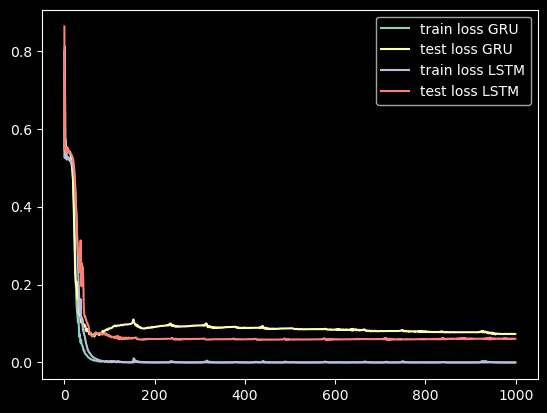

In [22]:
plt.plot(loss1, label="train loss GRU")
plt.plot(test1, label="test loss GRU")
plt.plot(loss2, label="train loss LSTM")
plt.plot(test2, label="test loss LSTM")
plt.legend()
plt.show()

In [36]:
# Evaluate by doing some prediction
X_last1 = X_test[0].view(T)
X_last2 = X_test[0].view(T)
predictions1 = []
predictions2 = []

while len(predictions1) != len(y_test) // 2:
    y_hat1 = model1(X_last1.reshape(1, T, 1))
    y_hat2 = model2(X_last2.reshape(1, T, 1))
    
    predictions1.append(y_hat1[0, 0].item())
    predictions2.append(y_hat2[0, 0].item())
    
    X_last1 = torch.cat((X_last1[1:], y_hat1[0]))
    X_last2 = torch.cat((X_last2[1:], y_hat2[0]))

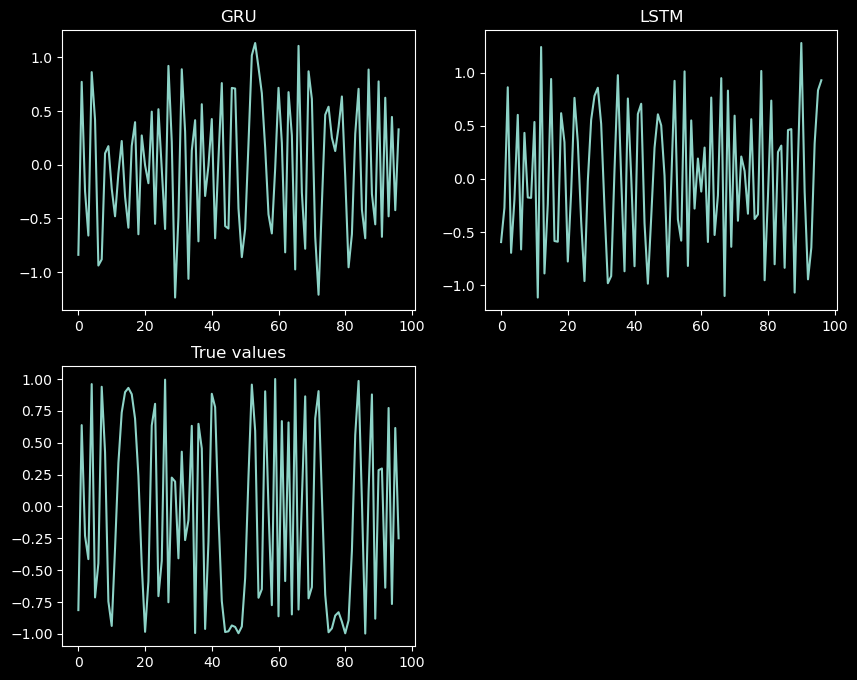

In [38]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("GRU")
plt.plot(predictions1)
plt.subplot(2, 2, 2)
plt.title("LSTM")
plt.plot(predictions2)
plt.subplot(2, 2, 3)
plt.title("True values")
plt.plot(y_test[:-len(y_test) // 2])
plt.show()